# Power Consumption Exploration of HTCC AB01

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
power_df = pd.read_csv('ppk2.csv')
power_df = power_df.rename(columns={'Timestamp(ms)': 'time', 'Current(uA)': 'current'})

# ppk2 for some reason warps time... I measured it and it's timestamps occur approximately 1/3 slower than they should
# I have found external validation that my assumption is correct: https://devzone.nordicsemi.com/f/nordic-q-a/103942/ppk2-wrong-time-scale-and-how-to-work-around-it
dilation = 3
power_df['time'] = power_df['time']/(10**3)*dilation
power_df['current'] = power_df['current']/(10**3)*dilation

# ppk2 also warps current?
power_led_df = pd.read_csv('ppk2_led.csv')
power_led_df = power_led_df.rename(columns={'Timestamp(ms)': 'time', 'Current(uA)': 'current'})
power_led_df['time'] = power_led_df['time']/(10**3)
power_led_df['current'] = power_led_df['current']/(10**3)

power_df.head()

,time,current
0,0.00000,0.0
1,0.00003,0.0
2,0.00006,0.0
3,0.00009,0.0
4,0.00012,0.0


In [66]:
cutoff = 12.5 * dilation

joining_times = power_df['time'][power_df['time'] < cutoff]
joining_currents = power_df['current'][power_df['time'] < cutoff]

sending_times = power_df['time'][power_df['time'] >= cutoff]
sending_currents = power_df['current'][power_df['time'] >= cutoff]

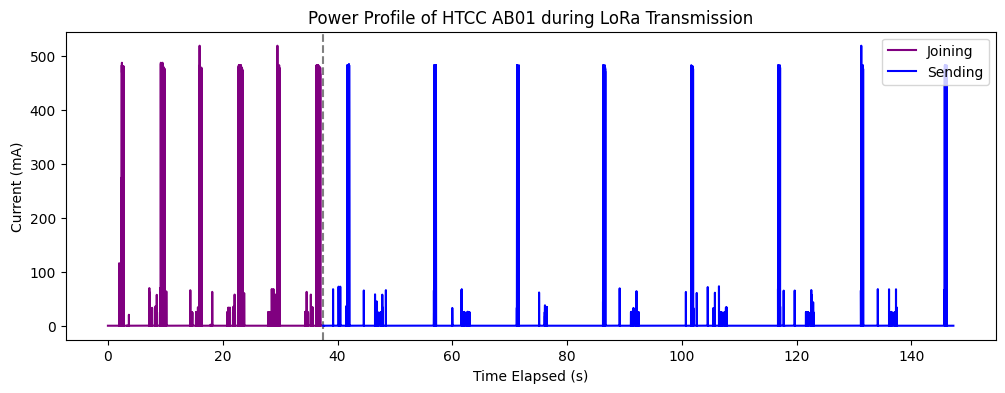

In [69]:
plt.figure(figsize=(12, 4))
plt.plot(joining_times, joining_currents, color='purple', label='Joining')
plt.axvline(x=cutoff, color='gray', linestyle='--')
plt.plot(sending_times, sending_currents, color='blue', label='Sending')

plt.title('Power Profile of HTCC AB01 during LoRa Transmission')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper right')
plt.show()

In [70]:
# Total

auc = np.trapz(power_df['current'], power_df['time'])
print(f"AUC: {auc.round(3)} mA*s")
print(f"Operating at 3.3V: {3.3 * auc.round(3) / 1000} J")

AUC: 835.76 mA*s
Operating at 3.3V: 2.758008 J


In [75]:
# Joining

print(f"Operating at 3.3V: {3.3 * 3*150 / 1000} J")

Operating at 3.3V: 1.4849999999999999 J
